In [ ]:
from newspaper import Article
from bs4 import BeautifulSoup
import requests
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from collections import defaultdict
import re


PAYWALL_TEXT = "For subscribers"  

articles_by_date = defaultdict(lambda: {"titles": [], "summaries": [], "urls": []})
paywalled_articles = 0
non_paywall_article_count = 0

def extract_published_date(article_html):

    pattern = r'Published(?:\s|&nbsp;|<!--.*?-->)+([A-Za-z]+\s+\d{1,2},\s+\d{4})'   
    match = re.search(pattern, article_html)
    if match:
        date_str = match.group(1)  
        try:
            date_obj = datetime.strptime(date_str, "%b %d, %Y")
            return date_obj.strftime("%Y-%m-%d")
        except:
            return None
    return None


def extract_article(loc_text):
    global paywalled_articles, non_paywall_article_count
    
    try:
        article = Article(loc_text)
        article.download()
        html = article.html
        
        # Check paywall
        if PAYWALL_TEXT in html:
            paywalled_articles += 1
            return None
        
        # Extract date
        published_date = extract_published_date(html)
        if not published_date:
            print(f"Could not extract date from: {loc_text}")
            return None
        
        # Parse article
        article.parse()
        article.nlp()
        
        # Store article info
        articles_by_date[published_date]["titles"].append(article.title)
        articles_by_date[published_date]["summaries"].append(article.summary)
        articles_by_date[published_date]["urls"].append(loc_text)
        
        non_paywall_article_count += 1
        print(f"✓ {published_date}: {article.title}")
        
    except Exception as e:
        print(f"Error processing {loc_text}: {e}")

urls_to_parse = []

for month in range(10, 0, -1): 
    url = f"https://www.straitstimes.com/sitemap/2025/{month}/feeds.xml"
    soup = BeautifulSoup(requests.get(url).content, "xml")
    
    for loc in soup.find_all("loc"):
        if "/business/" in loc.text:
            urls_to_parse.append(loc.text)

# Number of threads (adjust based on your system)
max_threads = 15

with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = [executor.submit(extract_article, url) for url in urls_to_parse]
    
    # Optional: wait for all tasks and show progress
    for future in as_completed(futures):
        future.result()  # triggers exception if any


✓ 2025-11-01: Wall Street gains on Amazon boost but rate caution tempers enthusiasm
✓ 2025-10-31: Singapore shares fall amid mixed regional trading
✓ 2025-10-31: CapitaLand Ascendas Reit Q3 occupancy and rental
✓ 2025-10-31: Manufacturing, services firms more upbeat but largely cautious about Q4 outlook: Survey
✓ 2025-10-31: China factory activity sees longest slump in almost a decade
✓ 2025-11-01: Quantum AI venture fund boosts Singapore's tech hub ambitions
✓ 2025-10-31: Twelve Cupcakes under MOM probe for unpaid salaries, abrupt retrenchment of 80 staff
✓ 2025-10-31: SIA earnings likely to stay ‘pressured’ despite over 380,000 discounted tickets, say analysts
✓ 2025-10-31: Apple sees blockbuster holiday season on new iPhones, driving up shares
✓ 2025-10-31: Cordlife’s executive chairman resigns after less than 5 months in the role
✓ 2025-10-31: Nvidia forges AI deals with South Korea’s biggest companies
✓ 2025-10-31: Nissan warns of $2.3 billion full-year loss, challenges ahead
✓ 20

In [40]:
import pandas as pd
df = pd.DataFrame(non_paywall_business_articles, columns=["url", "date"])

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date_only'] = df['date'].dt.normalize()
test_article = df[df["date"].dt.month == 10]
df["Month"] = df["date"].dt.month

df["Month"].value_counts().sort_index()

Month
1     238
2     291
3     239
4     260
5     266
6     253
7     272
8     291
9     303
10    285
11      5
Name: count, dtype: int64

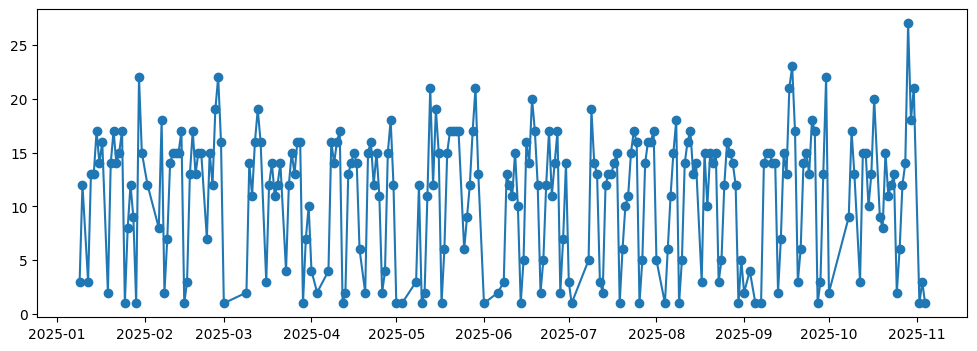

In [ ]:
import matplotlib.pyplot as plt

# Plot number of articles per day (including weekdays)

df1 = df["date_only"].value_counts().sort_index().reset_index()
df1 

plt.figure(figsize=(12, 4))
plt.plot(df1['date_only'], df1['count'], marker='o')

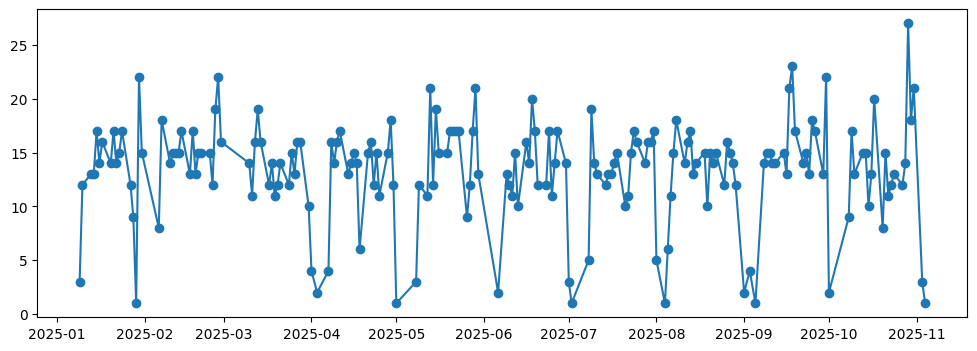

In [ ]:
# Plot number of articles per day (weekdays only)

df_weekdays = df[df['date'].dt.dayofweek < 5]
df2 = df_weekdays["date_only"].value_counts().sort_index().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(df2['date_only'], df2['count'], marker='o')

In [42]:
df2["count"].mean()

13.368983957219251